Starting Phase 4: GNN Models Implementation
Using device: cuda
Loaded 416 graphs
Number of node features per node: 8
Train: 265, Val: 67, Test: 84
Epoch 1/200, Train Loss: 4.3363, Val F1: 0.4322
Epoch 2/200, Train Loss: 2.6740, Val F1: 0.6184
Epoch 3/200, Train Loss: 3.5879, Val F1: 0.4322
Epoch 4/200, Train Loss: 2.5519, Val F1: 0.5200
Epoch 5/200, Train Loss: 3.0333, Val F1: 0.1928
Epoch 6/200, Train Loss: 3.6512, Val F1: 0.4322
Epoch 7/200, Train Loss: 2.1467, Val F1: 0.6184
Epoch 8/200, Train Loss: 1.3413, Val F1: 0.5228
Epoch 9/200, Train Loss: 1.7419, Val F1: 0.6184
Epoch 10/200, Train Loss: 1.8725, Val F1: 0.4322
Epoch 11/200, Train Loss: 1.7258, Val F1: 0.4322
Epoch 12/200, Train Loss: 2.3434, Val F1: 0.6436
Epoch 13/200, Train Loss: 1.4036, Val F1: 0.6184
Epoch 14/200, Train Loss: 1.1586, Val F1: 0.7021
Epoch 15/200, Train Loss: 1.1933, Val F1: 0.6857
Epoch 16/200, Train Loss: 1.7894, Val F1: 0.5174
Epoch 17/200, Train Loss: 1.1279, Val F1: 0.6184
Epoch 18/200, Train Loss: 0.8

C:\Users\rakes\AppData\Local\Temp\ipykernel_9832\1866653713.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gcn_model.load_state_dict(torch.load(best_model_path))


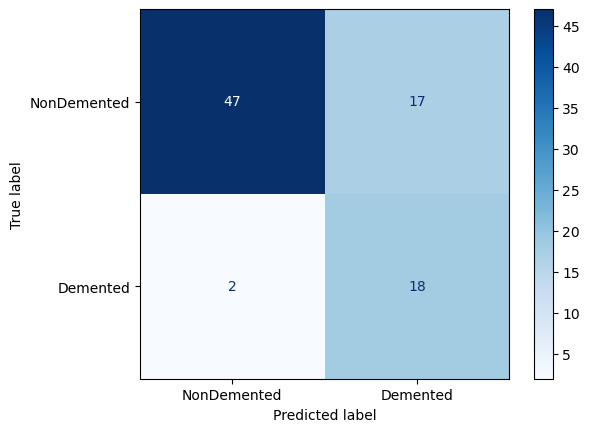

In [ ]:
# %% 
# 03_Phase_4_GNN.ipynb
# Phase 4: GNN-based Brain Graph Classification
print("Starting Phase 4: GNN Models Implementation")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.abspath('..'))  # Adjust if needed
from config.paths import *

# Ensure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# %% 
# 1. Load processed graph dataset
graph_dataset_path = os.path.join(PROCESSED_DIR, 'oasis_graph_dataset.pt')
graph_list = torch.load(graph_dataset_path, weights_only=False)
print(f"Loaded {len(graph_list)} graphs")

# %% 
# 2. Load clinical CSV
clinical_csv_path = os.path.join(PROCESSED_DIR, 'oasis_processed_metadata.csv')
clinical_df = pd.read_csv(clinical_csv_path)

# Preprocess clinical features
cols = ['Gender','Age','Education','MMSE','TIV','WBV','ASF','Delay']
clinical_df_subset = clinical_df[cols].copy()

# Encode categorical features
clinical_df_subset['Gender'] = clinical_df_subset['Gender'].map({'M':0,'F':1}).fillna(0)

# Fill missing numeric values
for col in ['Age','Education','MMSE','TIV','WBV','ASF','Delay']:
    clinical_df_subset[col] = pd.to_numeric(clinical_df_subset[col], errors='coerce')
    clinical_df_subset[col] = clinical_df_subset[col].fillna(clinical_df_subset[col].mean())

# Attach features to each graph
for i, g in enumerate(graph_list):
    feat = clinical_df_subset.iloc[i].values.astype(np.float32)
    g.x = torch.tensor(np.tile(feat, (g.num_nodes, 1)), dtype=torch.float)

num_node_features = graph_list[0].x.shape[1]
print("Number of node features per node:", num_node_features)

# %% 
# 3. Split dataset & create DataLoaders
from sklearn.model_selection import train_test_split

labels = [0 if g.y.item()==0 else 1 for g in graph_list]  # 0: NonDemented, 1: Demented

train_graphs, test_graphs = train_test_split(graph_list, test_size=0.2, stratify=labels, random_state=42)
train_graphs, val_graphs = train_test_split(train_graphs, test_size=0.2, stratify=[g.y.item() for g in train_graphs], random_state=42)

train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=16)
test_loader = DataLoader(test_graphs, batch_size=16)

print(f"Train: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")

# %% 
# 4. Define GCN model
# class BrainGCN(nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
#         super().__init__()
#         self.conv1 = GCNConv(in_channels, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, hidden_channels)
#         self.fc = nn.Linear(hidden_channels, out_channels)
#         self.dropout = dropout

#     def forward(self, data):
#         x, edge_index, batch = data.x, data.edge_index, data.batch
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, p=self.dropout, training=self.training)
#         x = self.conv2(x, edge_index)
#         x = F.relu(x)
#         x = global_mean_pool(x, batch)
#         x = self.fc(x)
#         return x
# =========================
# BrainGCN Model
# =========================
class BrainGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(BrainGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = dropout

        # Final Linear layer = Logistic Regression
        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # GCN Layer 1
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # GCN Layer 2
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Global pooling → Graph embedding
        x = global_mean_pool(x, batch)

        # Classifier (Logistic Regression)
        out = self.fc(x)
        return out

    # 🔹 Extra function: Get embeddings (before LR layer)
    def get_graph_embedding(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = global_mean_pool(x, batch)
        return x
# %% 
# 5. Instantiate model, optimizer, loss
num_classes = 2
gcn_model = BrainGCN(in_channels=num_node_features, hidden_channels=64, out_channels=num_classes, dropout=0.5).to(device)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.001, weight_decay=5e-4)

# Compute class weights
class_counts = [sum(labels==0 for labels in labels), sum(labels==1 for labels in labels)]
total_samples = sum(class_counts)
class_weights = torch.tensor([total_samples / (2.0 * c) for c in class_counts], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# %% 
# 6. Training and evaluation functions
def train_model(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def evaluate_model(model, loader):
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            ys.append(data.y.cpu())
            preds.append(pred.cpu())
    ys = torch.cat(ys)
    preds = torch.cat(preds)
    acc = accuracy_score(ys, preds)
    f1 = f1_score(ys, preds, average='macro')
    prec = precision_score(ys, preds, average='macro', zero_division=0)
    rec = recall_score(ys, preds, average='macro', zero_division=0)
    cm = confusion_matrix(ys, preds)
    return dict(accuracy=acc, f1=f1, precision=prec, recall=rec, cm=cm)

# %% 
# 7. Train GCN model with early stopping
epochs = 200
best_f1 = 0
best_model_path = './gcn_best_model.pt'
patience = 20
no_improve = 0

for epoch in range(1, epochs + 1):
    train_loss = train_model(gcn_model, train_loader, optimizer, criterion)
    val_metrics = evaluate_model(gcn_model, val_loader)
    
    if val_metrics['f1'] > best_f1:
        best_f1 = val_metrics['f1']
        torch.save(gcn_model.state_dict(), best_model_path)
        no_improve = 0
    else:
        no_improve += 1
    
    print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val F1: {val_metrics['f1']:.4f}")
    
    if no_improve >= patience:
        print("Early stopping triggered")
        break

# %% 
# 8. Load best model and evaluate on test set
gcn_model.load_state_dict(torch.load(best_model_path))
test_metrics = evaluate_model(gcn_model, test_loader)

print(f"Final Test -- Acc: {test_metrics['accuracy']:.4f}, F1: {test_metrics['f1']:.4f}, "
      f"Precision: {test_metrics['precision']:.4f}, Recall: {test_metrics['recall']:.4f}")

# Display confusion matrix
ConfusionMatrixDisplay(confusion_matrix=test_metrics['cm'], display_labels=["NonDemented", "Demented"]).plot(cmap='Blues')
plt.show()
